In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE, simulate_for_sbi
import torch

from sbi import utils as sbi_utils
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

/home/sam/miniconda3/envs/pandora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define system of equations
def mass_spring_damper(y, t, m, k, b):
    x, v = y
    F = np.interp(t, t_data, x_data[0, :, 0])
    dxdt = v
    dvdt = (F - b * v - k * x) / m
    return [dxdt, dvdt]


def mass_spring_damper_simulator(params):
    m, k, b = params
    t = np.linspace(0, 10, num_timesteps)  # Simulation time steps

    # Solve the system
    x0 = [0, 0]  # Initial position and velocity
    sol = odeint(mass_spring_damper, x0, t, args=(m, k, b))

    # Extract state variables
    x = sol[:, 0]
    v = sol[:, 1]

    # Get summary statistics
    stats = extract_summary_statistics(t, x, v)

    return stats



def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats


In [3]:
# Configuration
num_samples = 100
t_max = 20
num_timesteps = 64
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

In [4]:
# Prior distribution for (m, k, b) — assuming you know rough ranges
prior = sbi_utils.BoxUniform(low=torch.tensor([0.1, 0.1, 0.1]),
                                    high=torch.tensor([10.0, 10.0, 10.0]))

prior, num_parameters, prior_returns_numpy = process_prior(prior)

simulator_wrapper = process_simulator(
    mass_spring_damper_simulator,
    prior,
    prior_returns_numpy
)

check_sbi_inputs(simulator_wrapper, prior)

# Create inference object
inference = NPE(prior)

In [5]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)

100%|██████████| 10000/10000 [12:25<00:00, 13.42it/s]


In [6]:
# Train the inference network
density_estimator = inference.append_simulations(theta, x).train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 122 epochs.

In [13]:
# Observe a new system response
observed_data = mass_spring_damper_simulator([9.7, 5.0, 2.0])
observed_data = torch.tensor(observed_data, dtype=torch.float32)
# Infer parameters
samples = posterior.sample((100000,), x=observed_data)
m_inferred, k_inferred, b_inferred = samples.mean(dim=0)
print(f"Inferred m, k, b: {m_inferred}, {k_inferred}, {b_inferred}")

Drawing 100000 posterior samples: 101480it [00:01, 90774.67it/s]                           

Inferred m, k, b: 8.77245044708252, 5.016533851623535, 2.011841297149658


In [26]:
sample = prior.sample((1,))
observed_data_2 = mass_spring_damper_simulator(sample.numpy()[0])
observed_data_2 = torch.tensor(observed_data_2, dtype=torch.float32)
# Infer parameters
samples_2 = posterior.sample((100000,), x=observed_data_2)
m_inferred_2, k_inferred_2, b_inferred_2 = samples_2.mean(dim=0)
print(f"Sampled  m, k, b: {sample[0][0]}, {sample[0][1]}, {sample[0][2]}")
print(f"Inferred m, k, b: {m_inferred_2}, {k_inferred_2}, {b_inferred_2}")

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Sampled  m, k, b: 7.486773490905762, 2.8784236907958984, 2.032057046890259
Inferred m, k, b: 7.852940559387207, 2.940411329269409, 1.8177616596221924


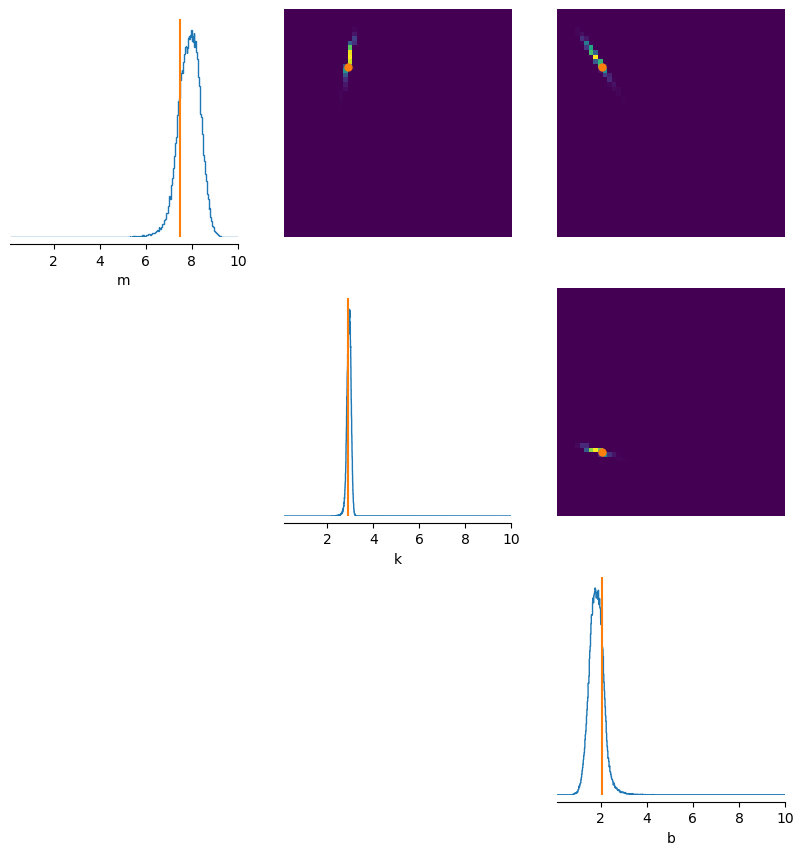

In [27]:
from sbi import analysis

fig, ax = analysis.pairplot(
    samples_2,
    points=sample,
    labels=["m", "k", "b"],
    limits=[[0.1, 10.0], [0.1, 10.0], [0.1, 10.0]]  # Prior limits for m, k, b
)